In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.sparse as sparse
from scipy.sparse import csr_matrix

import os
import os
import pickle
import math
import random
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Import data

In [2]:
INPUT_DIR = './input'
CLICKS_DIR = './input/clicks'

In [3]:
df_clicks = pd.DataFrame().append([pd.read_csv(CLICKS_DIR + "\\" + file, sep=",") for file in os.listdir(CLICKS_DIR)],
                                      ignore_index=True)

In [4]:
df_clicks.head(5)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [5]:
items_df = df_articles = pd.read_csv(INPUT_DIR + "\\" +"articles_metadata.csv", sep=",")

In [6]:
items_df.head(5)

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [7]:
embedding = pickle.load(open('./input/articles_embeddings.pickle', "rb"))
df_embeddings = pd.DataFrame(embedding)

In [8]:
df_embeddings.head(5)

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


---

In [9]:
df_clicks.shape

(2988181, 12)

In [10]:
print("*******************************************************")
print("df_clicks shape :", df_clicks.shape)
print("Number of unique users:", df_clicks["user_id"].nunique())
print("Number of unique articles:", df_clicks["click_article_id"].nunique())
print("*******************************************************")
print("items_df shape :", items_df.shape)
print("Number of unique categories:", items_df["category_id"].nunique())
print("Number of unique publishers:", items_df["publisher_id"].nunique())
print("Max word count:", items_df["words_count"].max())
print("*******************************************************")
print("embeddings shape shape :", embedding.shape)

*******************************************************
df_clicks shape : (2988181, 12)
Number of unique users: 322897
Number of unique articles: 46033
*******************************************************
items_df shape : (364047, 5)
Number of unique categories: 461
Number of unique publishers: 1
Max word count: 6690
*******************************************************
embeddings shape shape : (364047, 250)


## Item based approach (IBA)

### Prepare data

In [11]:
cb_df = df_clicks.copy()
cb_df.rename(columns = {"user_id": "user", "click_article_id": "item"}, inplace = True)
cb_df["click_counts"] = 1

In [12]:
def smooth_user_preference(x):
    """
    Smooth click counts :
    Input :
        - x (int) : number of clicks on an article for a single user
    Output :
        - (float) : smoothed number of clicks
    """

    return math.log(1+x, 2)

In [13]:
interactions_full = cb_df.groupby(["user", "item"])["click_counts"].sum().apply(smooth_user_preference).reset_index()

In [14]:
interactions_full

,user,item,click_counts
0,0,68866,1.0
1,0,87205,1.0
2,0,87224,1.0
3,0,96755,1.0
4,0,157541,1.0
...,...,...,...
2950705,322894,168401,1.0
2950706,322895,63746,1.0
2950707,322895,289197,1.0
2950708,322896,30760,1.0


In [15]:
interactions_train, interactions_test = train_test_split(interactions_full,
                                                      stratify = interactions_full["user"],
                                                      test_size=0.2,
                                                      random_state=90)

In [16]:
print("*******************************************************")
print("train set size :", interactions_train.shape)
print("test set size :", interactions_test.shape)

*******************************************************
train set size : (2360568, 3)
test set size : (590142, 3)


In [17]:
#Setting user as index
interactions_full_indexed = interactions_full.set_index("user")
interactions_train_indexed = interactions_train.set_index("user")
interactions_test_indexed = interactions_test.set_index("user")

### Create IBA model

In [18]:
interactions_train

,user,item,click_counts
817198,45687,233717,1.0
1329245,76236,160132,1.0
2602052,228634,107031,1.0
2158298,156841,121854,1.0
856774,47493,257291,1.0
...,...,...,...
1890477,126881,211483,1.0
1614807,98865,158536,1.0
711746,38856,198144,1.0
594546,30406,96635,1.0


In [19]:
class IBARecommender():
    # Recommend top 5 articles
    # Calculate a mean user profile based on his reading history
    # Find the most similar articles using cosine similarity
    
    def __init__(self, data, items_df, embedding):
        self.df = data.copy()
        self.items_df = items_df
        self.embedding = embedding
        
        self.item_ids = self.items_df["article_id"].unique().tolist()
        
    def inside_check(self):
        return self.df
    
    def get_single_item_profile(self, item_id):
        # input : article id / output : embedding data for article id
        idx = self.item_ids.index(item_id)
        item_profile = embedding[idx]

        return item_profile
    
    def get_multi_item_profile(self, ids):
        # input : list of article ids / output : matrix of embedding data for article ids
        items_profiles_list = [self.get_single_item_profile(x) for x in ids]
        
        return np.array(items_profiles_list)
    
    def build_single_user_profile(self, user_id):
        # Calculate user profile based on his history readings
        # input : user_id
        # output : user_items_clicks_count_weighted_av(np.array), one dimension array
        
        interactions_user_df = self.df.loc[user_id]
        user_items_profile = self.get_multi_item_profile(interactions_user_df["item"])
        
        user_items_clicks_count = np.array(interactions_user_df["click_counts"]).reshape(-1, 1)
        
        # Weighted average of item profiles by click count
        user_items_clicks_count_weighted_av = np.sum(np.multiply(user_items_profile, user_items_clicks_count),
                                                    axis=0) / np.sum(user_items_clicks_count)
        
        return user_items_clicks_count_weighted_av
    
    def get_similar_items_to_user_profile(self,user_id, topn=5):
        # Calculate similar items for a single user using cosine similarity
        # input : user_id / output : similar_items (list of tuples) - recomended items and similarity values
        
        user_vector = self.build_single_user_profile(user_id)
        
        # Compute cosine similarity between user profile and all items profikes
        cosine_sim = cosine_similarity([user_vector], embedding)
        
        # Get the top similar items
        similar_indices = cosine_sim.argsort().flatten()[-topn:]
        similar_items = sorted([(self.item_ids[i], cosine_sim[0, i]) for i in similar_indices],
                              key=lambda x: -x[1])
        
        return similar_items
    
    def get_items_interacted(self, user_id, interactions_df):
        # list of articles that have already been read by a single user
        # input : user_id, interactions_df / output = interacted_items_set - articles already read
        
        interacted_items = interactions_df.loc[user_id]["item"]
        interacted_items_set = set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])
        
        return interacted_items_set
    
    def recommend_items(self, user_id, df, items_to_ignore=[], topn=5, verbose=False):
        # Format recommend articles
        # input : user_id, items_to_ignore, topn - number of articles to return, verbose - extra info
        # output : recommendations_df - recommended items
        
        interacted_items = self.get_items_interacted(user_id, df)
        
        items_to_ignore.extend(interacted_items)
        similar_items = self.get_similar_items_to_user_profile(user_id, topn=topn+len(interacted_items))
        
        # Ignore items that user has already interacted with
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered,
                                         columns=["item", "similarity"]).head(topn)
        
        if verbose :
            if self.items_df is None:
                raise Exception("items_df is required in verbose mode")
            recommendations_df = recommendations_df.merge(items_df, how="left",
                                left_on="item",
                                right_on="article_id")[["item", "similarity", "category_id", "words_count"]]
        
        return recommendations_df
        
    def evaluate_perfo(self, n_users, k):
        # Calculate precision and recall for a sample of users
        # input : n_users - number of users used for perf calc, k - number of predicted items
        # output : precision, recall, f1_score
        
        user_indices = interactions_test_indexed.index.values.tolist()
        sample_users = random.sample(user_indices, n_users)
        
        precisions = []
        recalls = []
        
        for user_id in sample_users:
            try:
                actuals = interactions_train_indexed.loc[user_id, "item"].values
            except AttributeError:
                actuals = [(int(interactions_train_indexed.loc[user_id, "item"]))]
            predictions_df = self.recommend_items(user_id, interactions_test_indexed, topn=k)
            predictions = predictions_df["item"].values
            hits = len(set(actuals) & set(predictions))
            precision = hits / k
            recall = hits / len(actuals)
            precisions.append(precision)
            recalls.append(precision)
            recalls.append(recall)
        precision = np.mean(precisions)
        recall = np.mean(recalls)
        try:
            f1 = (2 * precision * recall) / (precision + recall)
        except ZeroDivisionError:
            f1 = 0             
        return [precision, recall, f1]


In [20]:
def display_user_reading_infos(user_id):
    user_df = interactions_full_indexed.copy()
    user_df = user_df.loc[user_id]
    user_df = user_df.merge(items_df, how="left",
                                left_on="item",
                                right_on="article_id")[["item", "click_counts", "category_id", "words_count"]]
    return user_df

In [21]:
def metric_1(df_1, df_2):
    categories_predicted = df_1.category_id.unique()
    categories_read = df_2.category_id.unique()
    total_categories_read = len(categories_read)
    
    correct = 0
    
    for categ in categories_predicted:
        if categ in categories_read:
            correct +=1
    
    return correct/total_categories_read

In [22]:
def metric_2(df_1, df_2):
    categories_predicted = df_1.category_id.unique()
    categories_read = df_2.category_id.unique()
    correct = 0
    
    for categ in categories_predicted:
        if categ in categories_read:
            correct +=1
    
    return correct/5

In [23]:
%%time
cb_model = IBARecommender(interactions_full_indexed, items_df, embedding)

Wall time: 37 ms


## Test

In [24]:
%%time
rec_items = cb_model.recommend_items(1, interactions_full_indexed,verbose=True)
rec_items

Wall time: 4.98 s


,item,similarity,category_id,words_count
0,237201,0.819216,375,182
1,346278,0.809952,440,203
2,156501,0.803289,281,226
3,234334,0.802575,375,201
4,280341,0.802565,412,150


In [25]:
user_1 = display_user_reading_infos(1)
user_1

,item,click_counts,category_id,words_count
0,36162,1.0,43,205
1,59758,1.0,123,213
2,96663,1.0,209,206
3,156723,1.0,281,154
4,160474,1.0,281,269
5,183176,1.0,301,285
6,205973,1.0,331,193
7,234481,1.0,375,212
8,235840,1.0,375,159
9,283392,1.0,412,226


In [26]:
print("Articles predicted that are from categories read by the user in the past:", round(metric_2(rec_items, user_1)*100), "%")
print("Percentage of categories liked by the user that are included in the prediction:", round(metric_1(rec_items, user_1)*100), "%")

Articles predicted that are from categories read by the user in the past: 60 %
Percentage of categories liked by the user that are included in the prediction: 33 %


## Performance

In [27]:
%%time
cb_perfos = cb_model.evaluate_perfo(n_users=100, k=5)
print("For 100 users:")
print("\tPrecision = {: .3f}".format(cb_perfos[0]))
print("\tRecall = {: .3f}".format(cb_perfos[1]))
print("\tf1_score = {: .3f}".format(cb_perfos[2]))

For 100 users:
	Precision =  0.010
	Recall =  0.008
	f1_score =  0.009
Wall time: 1min 52s


In [28]:
%%time
k_list = [1, 3, 5, 10]

cb_perfos_dict = dict()
for k in k_list:
    cb_perfos_dict[k] = cb_model.evaluate_perfo(n_users=100, k=k)

Wall time: 7min 20s


In [29]:
cb_perfos_dict

{1: [0.02, 0.012, 0.015],
 3: [0.01, 0.01125, 0.010588235294117648],
 5: [0.008, 0.006686237373737374, 0.007284357133645704],
 10: [0.006999999999999999, 0.004429196859903382, 0.005425469243266806]}

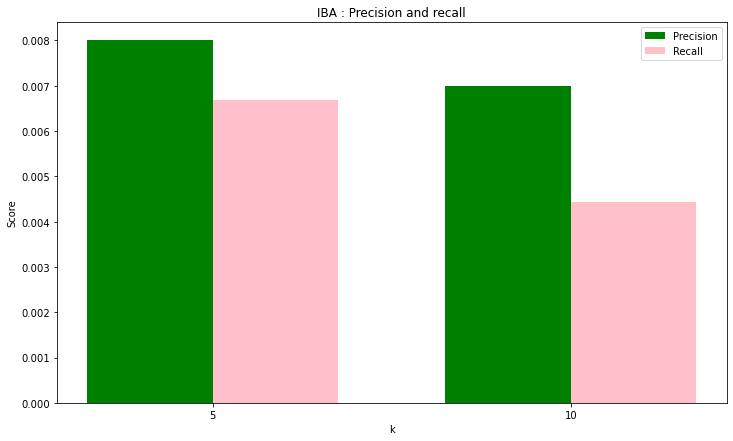

In [30]:
labels = [5, 10]

precision = [cb_perfos_dict[i][0] for i in labels]
recall = [cb_perfos_dict[i][1] for i in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax=plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width / 2, precision, width, label="Precision", color="green")
rects2 = ax.bar(x + width / 2, recall, width, label="Recall", color="pink")

ax.set_xlabel("k")
ax.set_ylabel("Score")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title("IBA : Precision and recall")
ax.legend()

plt.show()

---

In [31]:
metric_3 = []
metric_4 = []

In [32]:
%%time

k = 3
Art_pred_3 = []
Perc_cat_3 = []

for user_num in range(50):
    rec_items = cb_model.recommend_items(user_num, interactions_full_indexed,topn=k,verbose=True)
    user_1 = display_user_reading_infos(user_num)
    
    Art_pred_3.append(round(metric_2(rec_items, user_1)*100))
    Perc_cat_3.append(round(metric_1(rec_items, user_1)*100))
    
metric_3.append(sum(Art_pred_3)/len(Art_pred_3))
metric_4.append(sum(Perc_cat_3)/len(Perc_cat_3)) 

Wall time: 1min 3s


In [33]:
%%time

k = 5
Art_pred_5 = []
Perc_cat_5 = []

for user_num in range(50):
    rec_items = cb_model.recommend_items(user_num, interactions_full_indexed,topn=k,verbose=True)
    user_1 = display_user_reading_infos(user_num)
    
    Art_pred_5.append(round(metric_2(rec_items, user_1)*100))
    Perc_cat_5.append(round(metric_1(rec_items, user_1)*100))

metric_3.append(sum(Art_pred_5)/len(Art_pred_5))
metric_4.append(sum(Perc_cat_5)/len(Perc_cat_5)) 

Wall time: 60 s


In [34]:
%%time

k = 10
Art_pred_10 = []
Perc_cat_10 = []

for user_num in range(50):
    rec_items = cb_model.recommend_items(user_num,interactions_full_indexed,topn=k,verbose=True)
    user_1 = display_user_reading_infos(user_num)
    
    Art_pred_10.append(round(metric_2(rec_items, user_1)*100))
    Perc_cat_10.append(round(metric_1(rec_items, user_1)*100))
    
metric_3.append(sum(Art_pred_10)/len(Art_pred_10))
metric_4.append(sum(Perc_cat_10)/len(Perc_cat_10))    

Wall time: 1min 3s


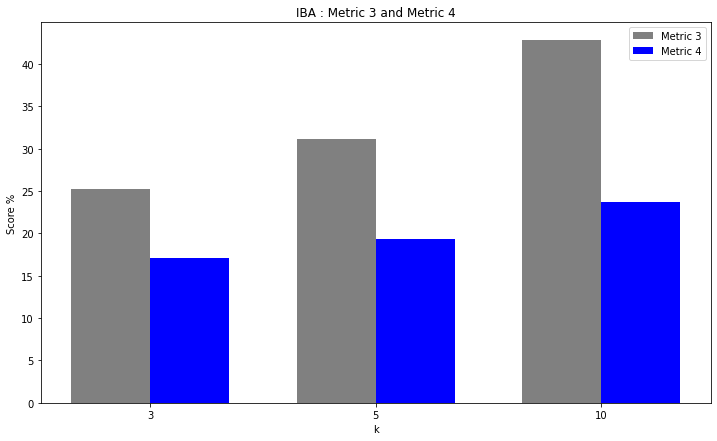

In [35]:
labels = [3, 5, 10]

x = np.arange(len(labels))
width = 0.35

fig, ax=plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width / 2, metric_3, width, label="Metric 3", color="grey")
rects2 = ax.bar(x + width / 2, metric_4, width, label="Metric 4", color="blue")

ax.set_xlabel("k")
ax.set_ylabel("Score %")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title("IBA : Metric 3 and Metric 4")
ax.legend()

plt.show()

## Content based approach (CBA)

### Create CBA model

In [36]:
class CBARecommender():
    def __init__(self, data, items, sample_size=None, save_lookup_dicts=False):
        
        self.df = data.copy()
        
        if not sample_size:
            self.sample_size = len(self.df)
        else:
            self.sample_size = sample_size
            
        self.items = items
        self.save_lookup_dicts = save_lookup_dicts
        
        self.create_sparse_matrix()
        
    def inside_check(self):
        # Just used to return internal variables for checking
        return self.user_to_sparse_user
        
    
    def smooth_user_preference(self, x):
        """
        Smooth click counts :
        Input :
            - x (int) : number of clicks on an article for a single user
        Output :
            - (float) : smoothed number of clicks
        """

        return math.log(1+x, 2)
    
    
    def map_ids(self, row, mapper):
        """
        Convert indices between sparse and compressed matrices :
        Input :
            - row (int) : index to convert
            - mapper (dict of int) : dictionary used for conversion
        Output :
            - (int) : converted index
        """

        return mapper[row]

        
    def prepare_data(self):
        """
        Process input dataframe to include only relevant information :
        """
            
        self.df = self.df[["user_id", "click_article_id"]]
        
        self.df.rename(columns={"user_id": "user", "click_article_id": "item"},
                      inplace=True)
        self.df["click_counts"] = 1
        self.df = self.df.groupby(["user", "item"])["click_counts"] \
                    .sum().apply(self.smooth_user_preference).reset_index()
        
        self.df.sort_values(by="user", axis=0, inplace=True)
        self.df = self.df[:self.sample_size]
    
    
        self.df["user"] = self.df["user"].astype("category")
        self.df["item"] = self.df["item"].astype("category")
        
        self.df["user_code"] = self.df["user"].cat.codes
        self.df["item_code"] = self.df["item"].cat.codes
        
        self.item_lookup = self.items[["article_id", "category_id"]].drop_duplicates()
        self.item_lookup.rename(columns={"article_id": "item", "category_id": "category"}, inplace=True)
   
    
    def create_sparse_matrix(self):
        """
        Transform spare data into a scipy sparse matrix to save memory.
        Calculate lookup dictionaries for indices conversions.
        """
        
        def save(obj, file_name, folder="./resources"):
            file_name = file_name + ".pkl"
            file_name = os.path.join(folder, file_name)
            with open(file_name, "wb") as f:
                pickle.dump(obj, f)
                
        def load(file_name, folder="./resources"):
            file_name = file_name + ".pkl"
            file_name = os.path.join(folder, file_name)
            with open(file_name, "rb") as f:
                loaded_file = pickle.load(f)
            return loaded_file        
                
        self.prepare_data()
        
        item_to_idx = {}
        idx_to_item = {}
        for (idx, item) in enumerate(self.df["item_code"].unique().tolist()):
            item_to_idx[item] = idx
            idx_to_item[idx] = item

        user_to_idx = {}
        idx_to_user = {}
        for (idx, user) in enumerate(self.df["user_code"].unique().tolist()):
            user_to_idx[user] = idx
            idx_to_user[idx] = user
         
        I = self.df["user_code"].apply(self.map_ids, args=[user_to_idx]).values
        J = self.df["item_code"].apply(self.map_ids, args=[item_to_idx]).values
        V = np.ones(I.shape[0])
        
        clicks = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
        self.clicks_sparse = clicks.tocsr()
        
        self.df["user_sparse_code"] = self.df["user_code"].map(user_to_idx)
        self.df["item_sparse_code"] = self.df["item_code"].map(item_to_idx)
        
        self.users_arr = np.sort(self.df["user_sparse_code"].unique()) # Get our unique customers
        self.items_arr = self.df["item_sparse_code"].unique() # Get our unique products that were purchased
        print("users_arr :\n", self.users_arr)
            
        if self.save_lookup_dicts:
            
            print("calcul des dictionnaires")
            save_dir = ".\resources"
            self.item_to_sparse_item = {}
            self.sparse_item_to_item = {}
            for sparse_item in self.df["item_sparse_code"].unique().tolist():
                item = self.df[self.df["item_sparse_code"] == sparse_item]["item"].tolist()[0]
                self.item_to_sparse_item[item] = sparse_item
                self.sparse_item_to_item[sparse_item] = item

            self.user_to_sparse_user = {}
            self.sparse_user_to_user = {}
            for sparse_user in self.df["user_sparse_code"].unique().tolist():
                user = self.df[self.df["user_sparse_code"] == sparse_user]["user"].tolist()[0]
                self.user_to_sparse_user[user] = sparse_user
                self.sparse_user_to_user[sparse_user] = user
                
            save(self.item_to_sparse_item, "item_to_sparse_item")
            save(self.sparse_item_to_item, "sparse_item_to_item")
            save(self.user_to_sparse_user, "user_to_sparse_user")
            save(self.sparse_user_to_user, "sparse_user_to_user")
            
        else:
            print("changement des dictionnaires")
            self.item_to_sparse_item = load("item_to_sparse_item")
            self.sparse_item_to_item = load("sparse_item_to_item")
            self.user_to_sparse_user = load("user_to_sparse_user")
            self.sparse_user_to_user = load("sparse_user_to_user")

    def make_train(self, pct_test = 0.2):
        testing_set = self.clicks_sparse.copy()
        testing_set[testing_set != 0] = 1
        training_set = self.clicks_sparse.copy()
        nonzero_ids = trainin_set.nonzero()
        nonzero_pairs = list(zip(nonzero_ids[0], nonzero_ids[1]))
        random.seed(0)
        num_samples = int(np.ceil(pct_test*len(nonzero_pairs)))
        samples = random.sample(nonzero_pairs, num_samples)
        user_inds = [index[0] for index in samples]
        item_inds = [index[1] for index in samples]
        training_set[user_inds, item_inds] = 0
        training_set.eliminate_zeros()
        
        return training_set, testing_set, list(set(user_inds))

    def fit_model(self, alpha=15, factors=20, regularization=0.1, iterations=10,
                 pct_test=0.2):
        """
        Calculate users and items matrices that will be used for recommendations (dot product)
        Input :
            - alpha (int) : 
            - factors (int) : second dimension of users and items matrices
            - regularization (float) : regularization coefficient
            - iteration (int) : number od epochs for model training
            - pct_test (float) : percentage of data masked in training set
        Output :
            - user_vecs (np.array) : matrix containing users features
            - item_vecs (np.array) : matrix containing articles features
        """
        
        testing_set = self.clicks_sparse.copy()
        testing_set[testing_set != 0] = 1
        training_set = self.clicks_sparse.copy()
        nonzero_ids = training_set.nonzero()
        nonzero_pairs = list(zip(nonzero_ids[0], nonzero_ids[1]))
        random.seed(0)
        num_samples = int(np.ceil(pct_test*len(nonzero_pairs)))
        samples = random.sample(nonzero_pairs, num_samples)
        user_inds = [index[0] for index in samples]
        item_inds = [index[1] for index in samples]
        training_set[user_inds, item_inds] = 0
        training_set.eliminate_zeros()
        
        self.test_set= testing_set
        self.train_set= training_set
        self.items_users_altered = list(set(user_inds))
        self.user_vecs, self.item_vecs = \
            implicit.alternating_least_squares((self.train_set*alpha).astype('double'), 
                                                              factors=factors, 
                                                              regularization=regularization, 
                                                              iterations=iterations)
        
        
        return self.user_vecs, self.item_vecs

    def rec_items(self, user_id, num_items = 5):
        user_id = self.user_to_sparse_user[user_id]
        user_ind = np.where(self.users_arr == user_id)[0][0]
        pref_vec = self.train_set[user_ind, :].toarray()
        pref_vec = pref_vec.reshape(-1) + 1
        pref_vec[pref_vec>1] = 0
        rec_vector = self.user_vecs[user_ind,:].dot(self.item_vecs.T)
        
        min_max=MinMaxScaler()
        rec_vector_scaled=min_max.fit_transform(rec_vector.reshape(-1, 1))[:,0]
        recommend_vector=pref_vec*rec_vector_scaled
        
        product_ids = np.argsort(recommend_vector)[::-1][:num_items]
        rec_list=[]
        
        for index in product_ids:
            code = self.items_arr[index]
            code = self.sparse_item_to_item[code]
            rec_list.append([code,
                            self.item_lookup["category"].loc[self.item_lookup["item"] == code].iloc[0]])
            
        codes = [item[0] for item in rec_list]
        
        descriptions = [item[1] for item in rec_list]
        final_frame = pd.DataFrame({"item":codes, "category":descriptions})
        
        return codes, final_frame[["item", "category"]]
    
    def auc_score(self,predictions, test):
        
        fpr, tpr, tresholds = metrics.roc_curve(test, predictions)
        
        return metrics.auc(fpr, tpr)
    
    
    def evaluate_perfo(self, n_users, k):
        # Calculate precision and recall for a sample of users
        # input : n_users - number of users used for perf calc, k - number of predicted items
        # output : precision, recall, f1_score
        
        predictions = [sparse.csr_matrix(self.user_vecs), sparse.csr_matrix(self.item_vecs.T)]
        store_auc = []
        precisions = []
        popularity_auc = []
        recalls = []
        
        pop_items = np.array(self.test_set.sum(axis=0)).reshape(-1)
        
        item_vecs = predictions[1]
        
        for user in self.items_users_altered:
            training_row = self.train_set[user,:].toarray().reshape(-1)
            zero_inds = np.where(training_row == 0)
            
            user_vec = predictions[0][user,:]
            pred = user_vec.dot(item_vecs).toarray()[0, zero_inds].reshape(-1)
            
            actual = self.test_set[user,:].toarray()[0,zero_inds].reshape(-1)
            
            pop = pop_items[zero_inds]
            store_auc.append(self.auc_score(pred, actual))
            popularity_auc.append(self.auc_score(pop, actual))
            
            read_items = np.where(actual == 1)[0]
            topk = np.flip(np.argsort(pred))[:k]
            hits = float(len(set(topk) & set(read_items)))
            precision = hits / k
            recall = hits / float(len(read_items))
            precisions.append(precision)
            recalls.append(recall)
        
        cf_auc = np.mean(store_auc)
        pop_auc = np.mean(popularity_auc)
        precision = np.mean(precisions)
        recall = np.mean(recalls)
        try:
            f1 = (2 * precision * recall) / (precision + recall)
        except ZeroDivisionError : 
            f1 = 0
            
        return [float("%.3f"%cf_auc),
                float("%.3f"%pop_auc),
                float("%.3f"%precision),
                float("%.3f"%recall),
                float("%.3f"%f1)
               ]
    def get_read_items(self, user_id):
        
        user_id = self.user_to_sparse_user[user_id]
        print("user_id: ", user_id)
        print("train_set: ", self.train_set)
        user_ind = np.where(self.users_arr == user_id)[0][0]
        print("user_ind: ", user_ind)
        purchased_ind = self.train_set[user_ind,:].nonzero()[1]
        print("purchased ind: ", purchased_ind)
        item_codes = [self.sparse_item_to_item[x] for x in purchased_ind]
        print("item codes: ", item_codes)
                
        return self.item_lookup.loc[self.item_lookup["item"].isin(item.codes)]


In [37]:
%%time
cf_model = CBARecommender(df_clicks, items_df, sample_size=100000, save_lookup_dicts=True)

users_arr :
 [   0    1    2 ... 4235 4236 4237]
calcul des dictionnaires
Wall time: 23.1 s


In [38]:
import implicit

In [39]:
user_vecs, item_vecs = cf_model.fit_model(iterations=10, pct_test=0.2)

This method is deprecated. Please use the AlternatingLeastSquares class instead


  0%|          | 0/10 [00:00<?, ?it/s]

In [40]:
print("user_vecs.shape :", user_vecs.shape)
print("item_vecs.shape :", item_vecs.shape)

user_vecs.shape : (4238, 20)
item_vecs.shape : (8648, 20)


#### Predictions

In [41]:
rec_items_list, rec_items_df = cf_model.rec_items(user_id=3, num_items=5)
print(rec_items_list)
rec_items_df

[68866, 272218, 235689, 237620, 251735]


,item,category
0,68866,136
1,272218,399
2,235689,375
3,237620,375
4,251735,388


#### Performance

In [42]:
cf_perfos = cf_model.evaluate_perfo(0, k=10)
print(cf_perfos)

[0.862, 0.917, 0.058, 0.162, 0.086]


In [43]:
%%time
k_list = [1, 3, 5, 10]

cf_perfos_dict = dict()
for k in k_list:
    cf_perfos_dict[k] = cf_model.evaluate_perfo(0, k=k)

Wall time: 1min 1s


In [44]:
cf_perfos_dict

{1: [0.862, 0.917, 0.104, 0.034, 0.051],
 3: [0.862, 0.917, 0.084, 0.08, 0.082],
 5: [0.862, 0.917, 0.073, 0.11, 0.087],
 10: [0.862, 0.917, 0.058, 0.162, 0.086]}

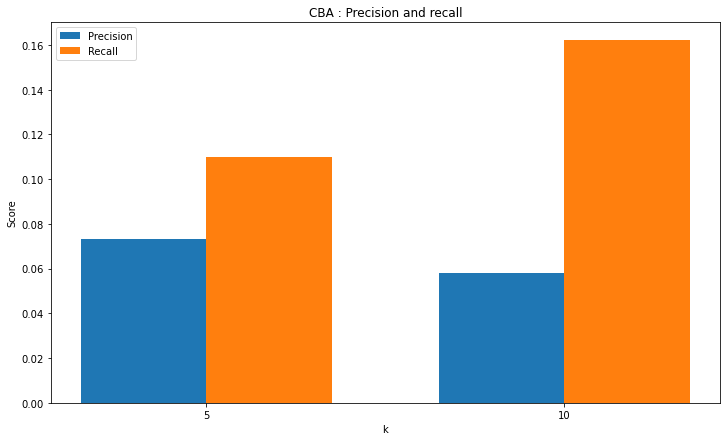

In [45]:
labels = [5, 10]

precision = [cf_perfos_dict[i][2] for i in labels]
recall = [cf_perfos_dict[i][3] for i in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax=plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width / 2, precision, width, label="Precision")
rects2 = ax.bar(x + width / 2, recall, width, label="Recall")

ax.set_xlabel("k")
ax.set_ylabel("Score")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title("CBA : Precision and recall")
ax.legend()

plt.show()

---

In [46]:
def metric_3(df_1, df_2):
    categories_predicted = df_1.category.unique()
    categories_read = df_2.category_id.unique()
    total_categories_read = len(categories_read)
    
    correct = 0
    
    for categ in categories_predicted:
        if categ in categories_read:
            correct +=1
    
    return correct/total_categories_read

In [47]:
def metric_4(df_1, df_2):
    categories_predicted = df_1.category.unique()
    categories_read = df_2.category_id.unique()
    correct = 0
    
    for categ in categories_predicted:
        if categ in categories_read:
            correct +=1
    
    return correct/5

In [48]:
metric_5 = []
metric_6 = []

In [49]:
%%time

k = 3
Art_pred_3 = []
Perc_cat_3 = []

for user_num in range(50):
    rec_items_list, rec_items_df = cf_model.rec_items(user_id=user_num, num_items=k)
    user_1 = display_user_reading_infos(user_num)
    
    Art_pred_3.append(round(metric_4(rec_items_df, user_1)*100))
    Perc_cat_3.append(round(metric_3(rec_items_df, user_1)*100))
    
metric_5.append(sum(Art_pred_3)/len(Art_pred_3))
metric_6.append(sum(Perc_cat_3)/len(Perc_cat_3)) 

Wall time: 4.16 s


In [50]:
%%time

k = 5
Art_pred_5 = []
Perc_cat_5 = []

for user_num in range(50):
    rec_items_list, rec_items_df = cf_model.rec_items(user_id=user_num, num_items=k)
    user_1 = display_user_reading_infos(user_num)
    
    Art_pred_5.append(round(metric_4(rec_items_df, user_1)*100))
    Perc_cat_5.append(round(metric_3(rec_items_df, user_1)*100))

metric_5.append(sum(Art_pred_5)/len(Art_pred_5))
metric_6.append(sum(Perc_cat_5)/len(Perc_cat_5)) 

Wall time: 4.52 s


In [51]:
%%time

k = 10
Art_pred_10 = []
Perc_cat_10 = []

for user_num in range(50):
    rec_items_list, rec_items_df = cf_model.rec_items(user_id=user_num, num_items=k)
    user_1 = display_user_reading_infos(user_num)
    
    Art_pred_10.append(round(metric_4(rec_items_df, user_1)*100))
    Perc_cat_10.append(round(metric_3(rec_items_df, user_1)*100))
    
metric_5.append(sum(Art_pred_10)/len(Art_pred_10))
metric_6.append(sum(Perc_cat_10)/len(Perc_cat_10))    

Wall time: 4.64 s


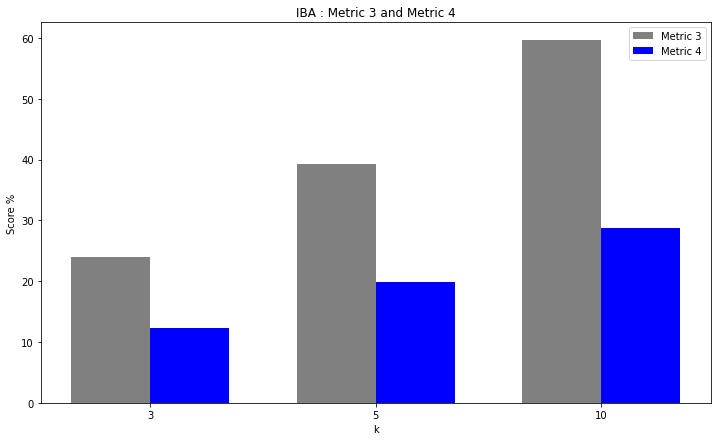

In [52]:
labels = [3, 5, 10]

x = np.arange(len(labels))
width = 0.35

fig, ax=plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width / 2, metric_5, width, label="Metric 3", color="grey")
rects2 = ax.bar(x + width / 2, metric_6, width, label="Metric 4", color="blue")

ax.set_xlabel("k")
ax.set_ylabel("Score %")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title("IBA : Metric 3 and Metric 4")
ax.legend()

plt.show()

---

## IBA vs CBA

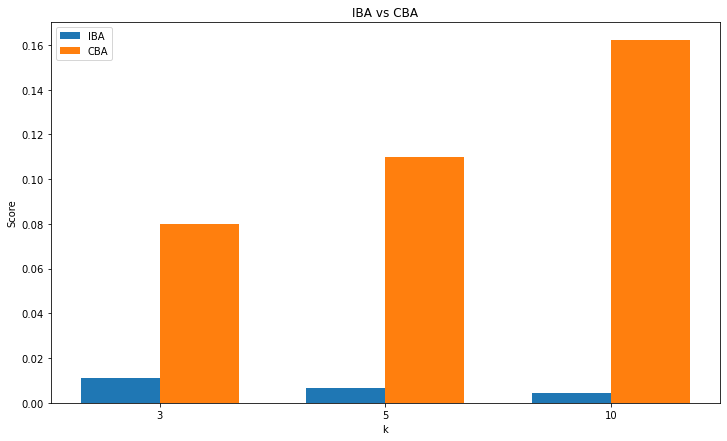

In [53]:
cb_recall = [cb_perfos_dict[i][1] for i in labels]
cf_recall = [cf_perfos_dict[i][3] for i in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax=plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width / 2, cb_recall, width, label="IBA")
rects2 = ax.bar(x + width / 2, cf_recall, width, label="CBA")

ax.set_xlabel("k")
ax.set_ylabel("Score")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title("IBA vs CBA")
ax.legend()

plt.show()

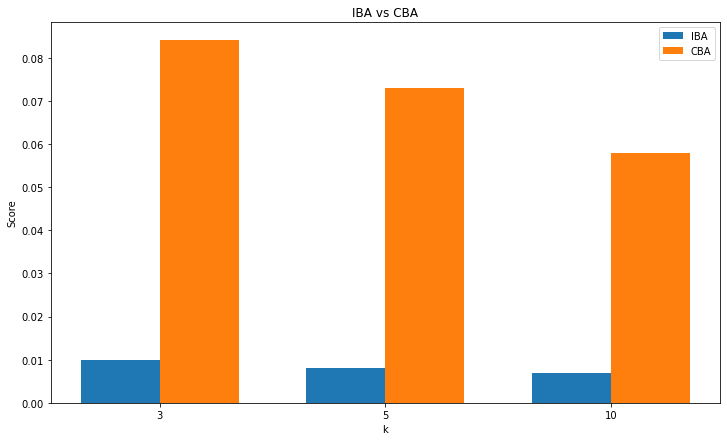

In [54]:
cb_precision = [cb_perfos_dict[i][0] for i in labels]
cf_precision = [cf_perfos_dict[i][2] for i in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax=plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width / 2, cb_precision, width, label="IBA")
rects2 = ax.bar(x + width / 2, cf_precision, width, label="CBA")

ax.set_xlabel("k")
ax.set_ylabel("Score")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title("IBA vs CBA")
ax.legend()

plt.show()

---

## Saving best model files

In [55]:
# user_vecs

np.save("user_vecs.npy", cf_model.user_vecs)

In [56]:
# item_vecs

np.save("item_vecs.npy", cf_model.item_vecs)

In [57]:
# clicks_sparse

scipy.sparse.save_npz("clicks.npz", cf_model.clicks_sparse)

In [58]:
cf_model.train_set

<4238x8648 sparse matrix of type '<class 'numpy.float64'>'
	with 80000 stored elements in Compressed Sparse Row format>

In [59]:
# users_arr

np.save("users_arr.npy", cf_model.users_arr)

In [60]:
# item_arr

np.save("items_arr.npy", cf_model.items_arr)

In [61]:
# user_to_sparse_user

with open("user_to_sparse_user.pkl", 'wb') as handle:

    pickle.dump(cf_model.user_to_sparse_user, handle)

In [62]:
# sparse_item_to_item

with open("sparse_item_to_item.pkl", 'wb') as handle:

    pickle.dump(cf_model.sparse_item_to_item, handle)

---

## Script for azure functions

In [63]:
import logging
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sparse
import scipy
import os
import tempfile
import json
import pickle

class CFR():
    def __init__(self,
                 user_vecs,
                 item_vecs,
                 clicks_sparse,
                 users_arr,
                 items_arr,
                 user_to_sparse_user,
                 sparse_item_to_item):
        
        self.user_vecs = user_vecs
        self.item_vecs = item_vecs
        self.clicks_sparse = clicks_sparse
        self.users_arr = users_arr
        self.items_arr = items_arr
        self.user_to_sparse_user = user_to_sparse_user
        self.sparse_item_to_item = sparse_item_to_item
        
    
    def rec_items(self, user_id, num_items = 5):
        """
        Calculate and return the recommnded items
        Input :
            - user_id (int) : user for whom recmmendations are calculated
            - num_items (int) : number of recommnded items
        Output :
            - codes (list of int) : recommended items
            - (pd.DataFrame) : recommended items and their attached category (for easier analysis)
        """
        
        user_id = self.user_to_sparse_user[user_id]
        user_ind = np.where(self.users_arr == user_id)[0][0] 
        pref_vec = self.clicks_sparse[user_ind,:].toarray() 
        pref_vec = pref_vec.reshape(-1) + 1 
        pref_vec[pref_vec > 1] = 0 
        rec_vector = self.user_vecs[user_ind,:].dot(self.item_vecs.T) 
       
        min_max = MinMaxScaler()
        rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0] 
        recommend_vector = pref_vec*rec_vector_scaled 
        
        product_idx = np.argsort(recommend_vector)[::-1][:num_items] 
       
        rec_list = [] 
        for index in product_idx:
            code = self.items_arr[index]
            code = self.sparse_item_to_item[code] 
            rec_list.append(code)
                             
        return rec_list


def init_model():  
    user_vecs = np.load("./trained-model/user_vecs.npy")
    #print("Avec fonction load_matrix : user_vecs.shape =", user_vecs.shape)

    item_vecs = np.load("./trained-model/item_vecs.npy")
    #print("Avec fonction load_matrix : item_vecs.shape =", item_vecs.shape)

    users_arr = np.load("./trained-model/users_arr.npy")
    #print("Avec fonction load_matrix : users_arr.shape =", users_arr.shape)

    items_arr = np.load("./trained-model/items_arr.npy")
    #print("Avec fonction load_matrix : items_arr.shape =", items_arr.shape)

    clicks = scipy.sparse.load_npz("./trained-model/clicks.npz")
    #print("Avec fonction load_matrix : clicks =\n")
    #print(clicks)

    with open("./trained-model/user_to_sparse_user.pkl", "rb") as f:
            user_to_sparse_user = pickle.load(f)

    with open("./trained-model/sparse_item_to_item.pkl", "rb") as f:
            sparse_item_to_item = pickle.load(f)

    cf_object = CFR(user_vecs,
                    item_vecs,
                    clicks,
                    users_arr,
                    items_arr,
                    user_to_sparse_user,
                    sparse_item_to_item)
    
    return cf_object
    
    
    
def reco_articles(user_id):

    model = init_model()
    recommendations = model.rec_items(user_id)

    print("recommendations for user {} :\n{}".format(user_id, recommendations))
    print("type(recommendations :", type(recommendations))
    
    return recommendations


In [64]:
reco_articles(1)[0]

recommendations for user 1 :
[96210, 20691, 336220, 288440, 336245]
type(recommendations : <class 'list'>


96210